In [1]:
import datetime
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
import sklearn.covariance as skcov

### Reading, setting index and converting to datetime

In [2]:
# reading, setting index and converting to datetime
data = pd.read_csv(r'stock_10_adj_close_2010_2021.csv')
data.Date = pd.to_datetime(data.Date)
data.set_index('Date', inplace=True)
data.head()

,AAPL,AMZN,GE,IBM,MSFT,NFLX,BA,KO,PEP,F
Date,,,,,,,,,,
2010-01-04,6.535084,6.6950,87.658882,83.320953,23.800224,7.640000,43.777538,19.357054,42.458454,6.852577
2010-01-05,6.546384,6.7345,88.112755,82.314430,23.807915,7.358571,45.211342,19.122900,42.971508,7.305856
2010-01-06,6.442255,6.6125,87.658882,81.779701,23.661806,7.617143,46.582806,19.116110,42.541645,7.579159
2010-01-07,6.430346,6.5000,92.197830,81.496635,23.415733,7.485714,48.468555,19.068598,42.271267,7.772473
2010-01-08,6.473095,6.6760,94.183647,82.314430,23.577221,7.614286,48.001015,18.715668,42.132599,7.792470


In [3]:
data.columns.to_list()

['AAPL', 'AMZN', 'GE', 'IBM', 'MSFT', 'NFLX', 'BA', 'KO', 'PEP', 'F']

### Choosing assets

In [4]:
np.random.seed(3)
# stocks num in portfolio
stocks_num = 5
cols = np.random.choice(data.columns, size=stocks_num, replace=False)
daily_data = data[cols]
daily_data.head()

,NFLX,MSFT,AMZN,GE,F
Date,,,,,
2010-01-04,7.640000,23.800224,6.6950,87.658882,6.852577
2010-01-05,7.358571,23.807915,6.7345,88.112755,7.305856
2010-01-06,7.617143,23.661806,6.6125,87.658882,7.579159
2010-01-07,7.485714,23.415733,6.5000,92.197830,7.772473
2010-01-08,7.614286,23.577221,6.6760,94.183647,7.792470


In [5]:
daily_data.columns.to_list()

['NFLX', 'MSFT', 'AMZN', 'GE', 'F']

### Returns and covariance matrix

In [6]:
def calc_returns(daily_data, *, log_returns=True, period='Y'):
    if log_returns:
        returns_daily = np.log((daily_data/daily_data.shift(1))).dropna()
    else:
        returns_daily = daily_data.pct_change().dropna()
    
    return returns_daily.resample(period).sum()

In [7]:
returns = calc_returns(daily_data, log_returns=False, period='Y')
returns.head()

,NFLX,MSFT,AMZN,GE,F
Date,,,,,
2010-12-31,1.348934,-0.058841,0.349096,0.233735,0.563190
2011-12-31,-0.689545,-0.018790,0.034918,0.059886,-0.365467
2012-12-31,0.524180,0.077611,0.420062,0.212876,0.235718
2013-12-31,1.571182,0.398286,0.500096,0.335365,0.230049
2014-12-31,0.015161,0.261553,-0.197648,-0.057524,0.058211


In [8]:
returns = calc_returns(daily_data, log_returns=True, period='Y')
returns.head()

,NFLX,MSFT,AMZN,GE,F
Date,,,,,
2010-12-31,1.189470,-0.082775,0.295864,0.196520,0.490583
2011-12-31,-0.930477,-0.046208,-0.039087,0.013293,-0.444948
2012-12-31,0.289881,0.056370,0.371065,0.195472,0.203761
2013-12-31,1.380364,0.366710,0.463500,0.321064,0.201442
2014-12-31,-0.074875,0.243453,-0.250734,-0.068962,0.036301


In [9]:
def calc_covariance(returns, *, shrinkage=False):
    if shrinkage:
        cov_yearly_oas, alpha = skcov.oas(returns)
        return pd.DataFrame(cov_yearly_oas)
    else:
        return returns.cov()

In [10]:
covariance = calc_covariance(returns, shrinkage=True)
covariance

,0,1,2,3,4
0,0.235953,0.008298,0.052991,0.019813,0.037576
1,0.008298,0.081792,0.003208,0.000673,0.009517
2,0.052991,0.003208,0.104260,0.003980,-0.001661
3,0.019813,0.000673,0.003980,0.126114,0.027376
4,0.037576,0.009517,-0.001661,0.027376,0.127196


In [11]:
covariance = calc_covariance(returns)
covariance

,NFLX,MSFT,AMZN,GE,F
NFLX,0.366548,0.018029,0.115134,0.043048,0.081642
MSFT,0.018029,0.031598,0.006971,0.001462,0.020678
AMZN,0.115134,0.006971,0.080414,0.008648,-0.003608
GE,0.043048,0.001462,0.008648,0.127897,0.059480
F,0.081642,0.020678,-0.003608,0.059480,0.130249


In [12]:
returns_mean = returns.mean()
# returns_mean.values.reshape(stocks_num, 1)
returns_mean

NFLX    0.363966
MSFT    0.220331
AMZN    0.267911
GE      0.006161
F       0.091427
dtype: float64

In [13]:
portfolios_num = 10000

def calc_volatility(x, covariance_matrix: np.array):
    return np.sqrt(x.T@covariance_matrix@x).item()

def calc_portfolios_monte_carlo(portfolios_num = 5000, covariance_matrix=None):
    portfolio_returns = []
    portfolio_volatility = []
    sharpe_ratio = []
    stock_weights = []
    for every_portfolio in range(portfolios_num):
        weights_raw = np.random.random(stocks_num).reshape(stocks_num,1)
        weights = weights_raw/weights_raw.sum()
        returns = (returns_mean.values.reshape(stocks_num, 1).T@weights).item()
        volatility = calc_volatility(weights, covariance_matrix)
        sharpe = returns / volatility
        portfolio_returns.append(returns)
        portfolio_volatility.append(volatility)
        sharpe_ratio.append(sharpe)
        stock_weights.append(weights)
        portfolio = {'returns': portfolio_returns,
                     'volatility': portfolio_volatility,
                     'sharpe_ratio': sharpe_ratio,}
    return pd.DataFrame(portfolio)

def calc_efficient_frontier(return_, covariance_matrix=None):
    # weights_initial = np.ones(stocks_num).reshape(stocks_num,1)/stocks_num
    weights_initial = np.ones(stocks_num)/stocks_num
    
    return_constr = {'type': 'eq',
                 'fun': lambda x: (returns_mean.values.reshape(stocks_num, 1).T@x).item() - return_
                }
    weights_constr = {'type': 'eq',
                 'fun': lambda x: np.sum(x) - 1
                }
    bnds = opt.Bounds(np.zeros_like(weights_initial), np.ones_like(weights_initial) * np.inf)

    res = opt.minimize(calc_volatility, weights_initial, args=(covariance_matrix), method='SLSQP', 
                   constraints=[return_constr, weights_constr], bounds=bnds)
    return res.x

In [14]:
portfolios_df = calc_portfolios_monte_carlo(portfolios_num = portfolios_num, covariance_matrix=covariance.values)
returns_range = np.arange(portfolios_df.returns.min(), portfolios_df.returns.max(), .01)
# returns_range

In [15]:
portfolios_df[:3]

,returns,volatility,sharpe_ratio
0,0.208070,0.263705,0.789023
1,0.218429,0.282706,0.772636
2,0.197683,0.275751,0.716891


In [16]:
weights_optimal = np.array(list(map(partial(calc_efficient_frontier, covariance_matrix=covariance.values), returns_range)))
volatilities_optimal = [calc_volatility(i, covariance.values) for i in weights_optimal]
shrp_argmax = (returns_range/volatilities_optimal).argmax()
ret_shrp_max = returns_range[shrp_argmax]
vol_shrp_max = volatilities_optimal[shrp_argmax]
max_sharpe_ratio = ret_shrp_max/vol_shrp_max
weights_max_sharpe = weights_optimal[shrp_argmax]
print(pd.DataFrame({'weights': weights_max_sharpe.round(3)}, index=cols).T)

         NFLX   MSFT   AMZN   GE    F
weights   0.0  0.667  0.333  0.0  0.0


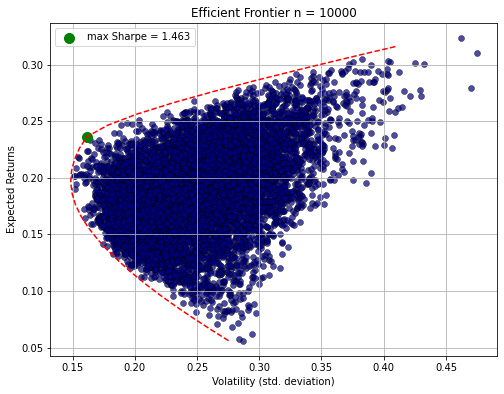

In [17]:
fig = plt.figure(num=1, figsize=(8, 6), dpi=72, facecolor='w')
plt.grid()
plt.scatter(portfolios_df.volatility, portfolios_df.returns, c='navy', linewidths=0.5, alpha=0.7, edgecolor='k');
plt.plot(volatilities_optimal, returns_range, 'r--')
plt.scatter(vol_shrp_max, ret_shrp_max, s=100, c='g', label=f'max Sharpe = {max_sharpe_ratio:.3f}')
plt.xlabel('Volatility (std. deviation)')
plt.ylabel('Expected Returns')
plt.title(f'Efficient Frontier n = {portfolios_num}')
plt.legend()
plt.show();

In [18]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

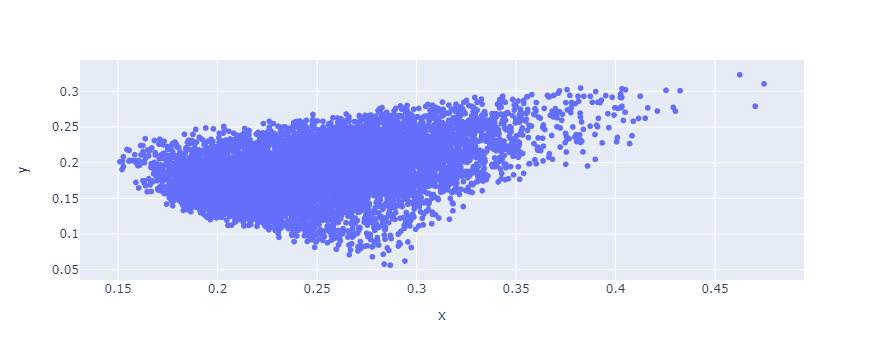

In [45]:
# fig = px.scatter(portfolios_df, x='volatility', y='returns', size='20')
fig = px.scatter(x=portfolios_df.volatility, y=portfolios_df.returns)
fig

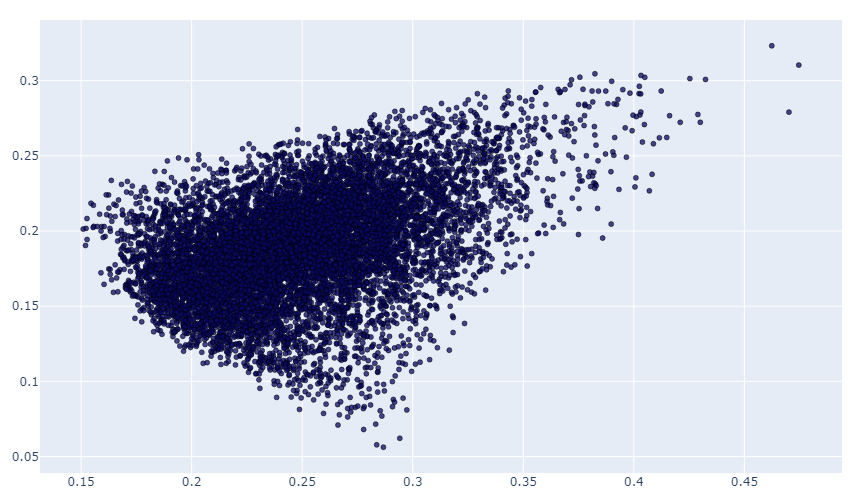

In [69]:
m = 20
data = go.Scatter(x=portfolios_df.volatility, y=portfolios_df.returns, mode='markers', 
                  marker=dict(color='rgba(10, 10, 100, 0.75)', size=5, line=dict(width=0.5, color='black')))
fig = go.Figure(data, layout=go.Layout(width=700, height=500, margin=go.layout.Margin(t=m, b=m, r=m, l=m)))
fig